# RDKit pandas support
This is a quick tutorial will show some of the ways you can use RDKit together with pandas.

@TAGS: #basics #pandas

In [1]:
from __future__ import print_function
%matplotlib inline

In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

# The next line is commented out 
# because GitHub does not render svg's embedded in notebooks
IPythonConsole.ipython_useSVG=False

Load the table of drugs (downloaded from [ChEMBL](https://www.ebi.ac.uk/chembl/) )

In [3]:
df = pd.read_csv('../data/chembl_drugs.txt.gz', sep='\t')

In [4]:
[str(x) for x in df.columns]

['PARENT_MOLREGNO',
 'CHEMBL_ID',
 'SYNONYMS',
 'DEVELOPMENT_PHASE',
 'RESEARCH_CODES',
 'APPLICANTS',
 'USAN_STEM',
 'USAN_STEM_DEFINITION',
 'USAN_STEM_SUBSTEM',
 'USAN_YEAR',
 'FIRST_APPROVAL',
 'ATC_CODE',
 'ATC_CODE_DESCRIPTION',
 'INDICATION_CLASS',
 'SC_PATENT_NO',
 'DRUG_TYPE',
 'RULE_OF_FIVE',
 'FIRST_IN_CLASS',
 'CHIRALITY',
 'PRODRUG',
 'ORAL',
 'PARENTERAL',
 'TOPICAL',
 'BLACK_BOX',
 'AVAILABILITY_TYPE',
 'WITHDRAWN_YEAR',
 'WITHDRAWN_COUNTRY',
 'WITHDRAWN_REASON',
 'CANONICAL_SMILES']

In [5]:
len(df)

11442

Keep only compounds with SMILES,that respect Ro5 and are on the market

In [6]:
df = df[df['CANONICAL_SMILES'].notnull() & # Keep cpds with SMILES
        (df['RULE_OF_FIVE'] == 'Y') & # that respect Ro5
        (df['DEVELOPMENT_PHASE'] == 4)] # are on the market

In [7]:
len(df)

1284

Table contains CANONICAL_SMILES with SMILES which we can convert to RDKit molecules (default name ROMol)

In [8]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='CANONICAL_SMILES')
#PandasTools.ChangeMoleculeRendering()

Remove rows where RDKit failed to generate a molecule from SMILES

In [9]:
df = df[~df['ROMol'].isnull()]

Extract a name from SYNONYMS column by applying a row-wise operation

In [10]:
df['name'] = df.apply(lambda x: x['SYNONYMS'].split('(')[0] if type(x['SYNONYMS']) is str else None, axis=1)

Depict first 8 mols

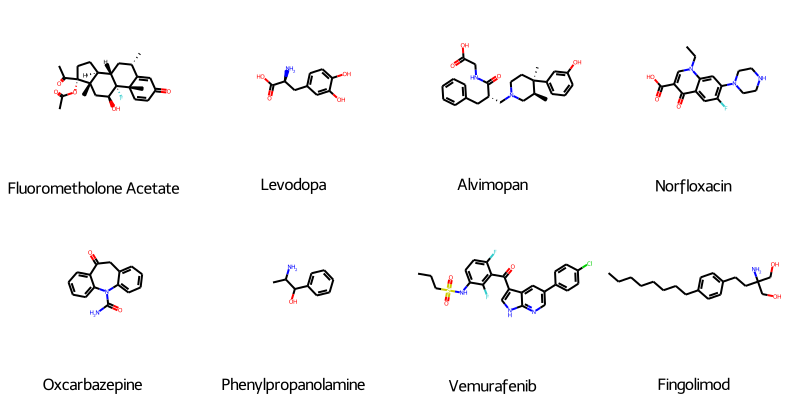

In [11]:
PandasTools.FrameToGridImage(df.head(8), legendsCol='name', molsPerRow=4)

Calculate some descriptors and visualize distributions

In [12]:
from rdkit.Chem import Descriptors

In [13]:
df['MW'] = df['ROMol'].map(Descriptors.MolWt)
df['logP'] = df['ROMol'].map(Descriptors.MolLogP)

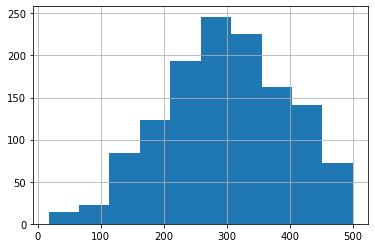

In [14]:
#doctest: IGNORE
df['MW'].hist();

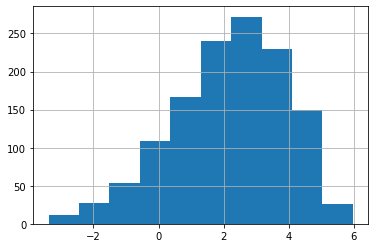

In [15]:
#doctest: IGNORE
df['logP'].hist();

Do a subsructure search on a dataframe

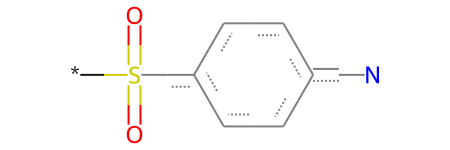

In [16]:
query = Chem.MolFromSmarts('Nc1ccc(S(=O)(=O)-[*])cc1')
query

Notice that unspecified bonds in the SMARTS are "single or aromatic" queries. We could make this query a bit more specific:

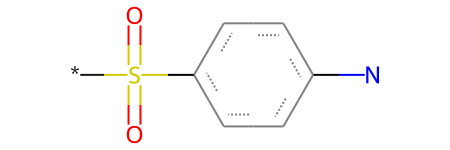

In [17]:
query = Chem.MolFromSmarts('N-c1ccc(-S(=O)(=O)-[*])cc1')
query

In [18]:
len(df[df['ROMol'] >= query])

35

RDKit by defaults highlights the matched substructures

,SYNONYMS,ROMol
45,"Sulfadimethoxine (BAN, INN, JAN, MI, NF, USP);...",
48,Bendrofluazide (BAN); Bendroflumethiazide (FDA...,
51,"Hydrochlorothiazide (BAN, FDA, INN, JAN, USP)",
155,"Sulfapyridine (BAN, FDA, INN, USP); Sulfapyrid...",
266,"Sulfaphenazole (BAN, FDA, INN, JAN, MI)",

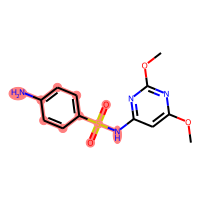
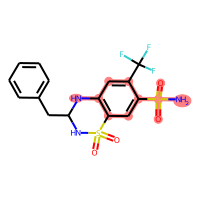
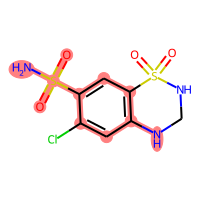
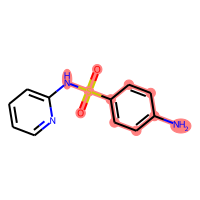
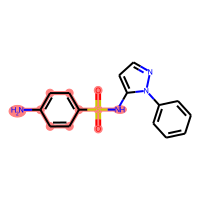

In [19]:
df[df['ROMol'] >= query][['SYNONYMS', 'ROMol']].head()

Save the table as SD file

In [20]:
PandasTools.WriteSDF(df, '../data/approved_drugs.sdf', idName='CHEMBL_ID', properties=df.columns)

Tutorial author: Samo Turk, Jan. 2017